In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split

import torch

from torch.utils.data import Dataset, DataLoader, Subset


c:\Users\lbj23\OneDrive\Рабочий стол\Ya_practicum_DLE\venv_sprint2project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Чистка текстов

In [2]:
with open('data/raw_dataset.txt', 'r', encoding='utf-8') as file:
    texts = [line.rstrip('\n') for line in file]
print(texts[:5])

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]


In [3]:
from src.data_utils import clean_text

texts = pd.Series(texts)
texts = texts.apply(clean_text)

texts.iloc[:5]

0    awww that's a bummer you shoulda got david car...
1    is upset that he can't update his facebook by ...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it's not behaving at all i'm mad why am i h...
dtype: object

(array([2.80366e+05, 4.33946e+05, 3.48718e+05, 2.64162e+05, 2.08839e+05,
        6.23110e+04, 2.07200e+03, 4.50000e+01, 2.50000e+01, 1.40000e+01]),
 array([ 0. ,  5.1, 10.2, 15.3, 20.4, 25.5, 30.6, 35.7, 40.8, 45.9, 51. ]),
 <BarContainer object of 10 artists>)

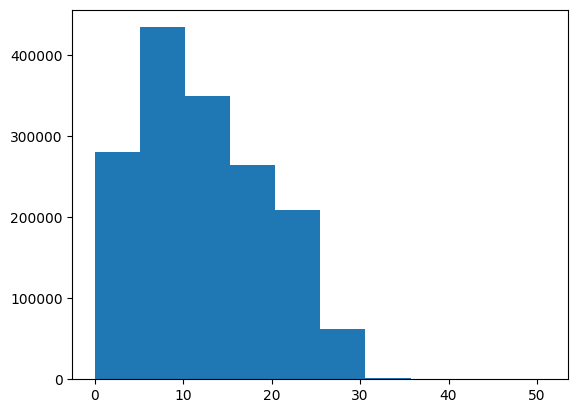

In [4]:
lengths = texts.apply(lambda x: len(x.split()))
plt.hist(lengths)

In [ ]:
texts.to_csv('data/dataset_processed.csv', index = False)

In [6]:
train_texts, test_texts = train_test_split(texts,
                                           test_size=0.2,
                                           random_state=42)

test_texts, val_texts = train_test_split(test_texts, 
                                         test_size=0.5,
                                         random_state=42)

print(f'train - {len(train_texts)}, test - {len(test_texts)}, val - {len(val_texts)}')

train - 1280398, test - 160050, val - 160050


### Создание Dataset, Dataloader

In [8]:
from src.next_token_dataset import NextTokenDataset, collate_fn

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 

train_dataset = NextTokenDataset(train_texts.to_list(), tokenizer)
val_dataset = NextTokenDataset(val_texts.to_list(), tokenizer, val_ds = True)
test_dataset = NextTokenDataset(test_texts.to_list(), tokenizer, val_ds = True)

print(f'train_dataset - {len(train_dataset)} \n val_dataset - {len(val_dataset)} \n test_dataset - {len(test_dataset)} \n')

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

print(f'train_dataloader - {len(train_dataloader)} \n val_dataloader - {len(val_dataloader)} \n test_dataloader - {len(test_dataloader)} \n')


train_dataset - 1123922 
 val_dataset - 96903 
 test_dataset - 96952 

train_dataloader - 4391 
 val_dataloader - 379 
 test_dataloader - 379 



In [9]:
torch.save(train_dataset, 'data/train.pt')
torch.save(val_dataset, 'data/val.pt')
torch.save(test_dataset, 'data/test.pt')

### Загрузка Dataset

In [95]:
from src.next_token_dataset import NextTokenDataset, collate_fn

train_dataset = torch.load('data/train.pt', weights_only = False)
val_dataset = torch.load('data/val.pt', weights_only = False)
test_dataset = torch.load('data/test.pt', weights_only = False)

print(f'train_dataset - {len(train_dataset)}')
print(f'val_dataset - {len(val_dataset)}')
print(f'test_dataset - {len(test_dataset)}')

Exception ignored in: <function tqdm.__del__ at 0x000002254E563F60>
Traceback (most recent call last):
  File "c:\Users\lbj23\OneDrive\Рабочий стол\Ya_practicum_DLE\venv_sprint2project\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\lbj23\OneDrive\Рабочий стол\Ya_practicum_DLE\venv_sprint2project\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


train_dataset - 1123922
val_dataset - 96903
test_dataset - 96952


In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [97]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

print(f'train_dataloader - {len(train_loader)} \n val_dataloader - {len(val_loader)} \n')


train_dataloader - 4391 
 val_dataloader - 379 



### Тренировка модели

In [ ]:
from src.train_one_epoch import train_epoch
from src.evaluate_one_epoch import evaluate_epoch
from src.next_token_rnn import NextTokenRNN

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = NextTokenRNN(vocab_size=tokenizer.vocab_size, 
                     emb_dim = 300, 
                     hidden_dim=256, 
                     num_layers=2)

losses, roughes1, roughes2 = [], [], [] 
best_rough1 = 0
patience = 6

with open('training_procces.txt', 'a', encoding='utf-8') as file:
    for epoch in range(100): 
        loss = train_epoch(model, train_loader, device, tokenizer)
        rough1, rough2, starts, trues, preds = evaluate_epoch(model, val_loader, device, tokenizer)

        losses.append(loss)
        roughes1.append(rough1)
        roughes2.append(rough2)

        show_example = np.random.randint(0, batch_size)
        print(f'Epoch {epoch + 1}: loss {loss} -- rough1 {rough1} -- rough2 {rough2}')
        print(f'Example: \n Start: {starts[show_example]} \n True: {trues[show_example]} \n Prediction: {preds[show_example]}')
        
        file.write(f'Epoch {epoch + 1}: loss {loss} -- rough1 {rough1} -- rough2 {rough2} \n')
        file.write(f'Example: \n Start: {starts[show_example]} \n True: {trues[show_example]} \n Prediction: {preds[show_example]} \n\n')
        
        if rough1 > best_rough1:
            best_rough1 = rough1
            best_weights = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break 
    

100%|██████████| 379/379 [09:10<00:00,  1.45s/it]


Epoch 1: loss 4.862375015931204 -- rough1 0.10995383280497423 -- rough2 0.023518705679284792
Example: 
 Start: i tripped going down my stairs and my 
 True: mom started laughing 
 Prediction: nose is killing me


100%|██████████| 379/379 [09:42<00:00,  1.54s/it]


Epoch 2: loss 4.606536012987047 -- rough1 0.11114080295887624 -- rough2 0.024302443529126482
Example: 
 Start: i love when theres an update as soon 
 True: as i wake up 
 Prediction: as i can get a new phone


100%|██████████| 379/379 [09:26<00:00,  1.49s/it]


Epoch 3: loss 4.537194559878734 -- rough1 0.11577387445676486 -- rough2 0.026018717292146488
Example: 
 Start: hearing the crickets outside makes me 
 True: want to be camping 
 Prediction: sad


100%|██████████| 379/379 [09:22<00:00,  1.49s/it]


Epoch 4: loss 4.498147657481719 -- rough1 0.11729855952950745 -- rough2 0.02681691898287479
Example: 
 Start: i hate when it ' s cloudy i either want it to 
 True: be all sunny or raining it ' s cloudy 
 Prediction: be sunny


100%|██████████| 379/379 [10:11<00:00,  1.61s/it]


Epoch 5: loss 4.471625458051229 -- rough1 0.11603183573958033 -- rough2 0.02689465439489346
Example: 
 Start: so wats up can u please give me another chance i 
 True: promise i wouldnt mess up again 
 Prediction: ' m not a fan of the new moon trailer


100%|██████████| 379/379 [09:53<00:00,  1.57s/it]


Epoch 6: loss 4.45182155123932 -- rough1 0.11627754261856615 -- rough2 0.027068376380348088
Example: 
 Start: hi there just wanted to say i love your movies just like 
 True: the rest of the world 
 Prediction: you


100%|██████████| 379/379 [10:05<00:00,  1.60s/it]


Epoch 7: loss 4.436244512087553 -- rough1 0.11700692280678188 -- rough2 0.02727038859198219
Example: 
 Start: is distraught finking about peter andre and katie prices split they were 
 True: my only hope in true love 
 Prediction: all sold out


100%|██████████| 379/379 [09:58<00:00,  1.58s/it]


Epoch 8: loss 4.423826307893152 -- rough1 0.1169846111283028 -- rough2 0.02771865613297486
Example: 
 Start: uncle jay sorry to say but i didn ' t borrow it although i ' m sure i 
 True: would have had a ton of good laughs if i had 
 Prediction: ' ll be sure to get a new one


100%|██████████| 379/379 [09:42<00:00,  1.54s/it]


Epoch 9: loss 4.412826649612187 -- rough1 0.11752150901790755 -- rough2 0.02724133236366033
Example: 
 Start: good morning friends i ' m enjoying a cup of coffee and listening to the birds singing busy 
 True: day ahead it ' s a surprise so i can ' t say 
 Prediction: day


100%|██████████| 379/379 [09:42<00:00,  1.54s/it]


Epoch 10: loss 4.403547452810657 -- rough1 0.11718098321659993 -- rough2 0.027248190273321087
Example: 
 Start: no definitely not a spambot her profile has 2000 followers but she barely follows 
 True: some 800 people looks human enough to me 
 Prediction: me


100%|██████████| 379/379 [09:28<00:00,  1.50s/it]

Epoch 11: loss 4.395747203865998 -- rough1 0.1190793267629845 -- rough2 0.028030439955744873
Example: 
 Start: its raining outside how rad at least i 
 True: can breath some fresh air 
 Prediction: ' m not going to be able to go to the beach



100%|██████████| 379/379 [10:01<00:00,  1.59s/it]


Epoch 12: loss 4.3896345202837574 -- rough1 0.11835778346242332 -- rough2 0.027544515494484625
Example: 
 Start: im rly gonna miss swf good thing 
 True: im seeing them sat night 
 Prediction: i ' m not going to be able to go to the beach


100%|██████████| 379/379 [09:24<00:00,  1.49s/it]


Epoch 13: loss 4.383900704836688 -- rough1 0.11779519079949702 -- rough2 0.0279467778918593
Example: 
 Start: watchin college softball world serious b 
 True: ##4 i head to work 
 Prediction: ##day party


100%|██████████| 379/379 [09:25<00:00,  1.49s/it]


Epoch 14: loss 4.379746625592295 -- rough1 0.11845339717366937 -- rough2 0.027604777297074373
Example: 
 Start: for the final weekend of the season i predict hull and boro to go 
 True: down liverpool 2nd monaco lewis hamilton 
 Prediction: to the beach


100%|██████████| 379/379 [09:28<00:00,  1.50s/it]


Epoch 15: loss 4.3752792960444715 -- rough1 0.11801779303633167 -- rough2 0.02781884580665158
Example: 
 Start: omg i just found another secret video on the r 
 True: live dvd made me smile 
 Prediction: ##4


100%|██████████| 379/379 [09:32<00:00,  1.51s/it]

Epoch 16: loss 4.37189645990916 -- rough1 0.11886608367371426 -- rough2 0.027892331099270383
Example: 
 Start: well i do bk the problem is i 
 True: also do work 
 Prediction: ' m not a fan of the new moon trailer



100%|██████████| 379/379 [09:52<00:00,  1.56s/it]

Epoch 17: loss 4.369065961162312 -- rough1 0.11768497103118318 -- rough2 0.027820149272966672
Example: 
 Start: just got back from the wedding reception in an hour toe has evolved from jellybean to purple sm 
 True: ##urf stage if it had a face and a hat 
 Prediction: ##h
Early stopping at epoch 16


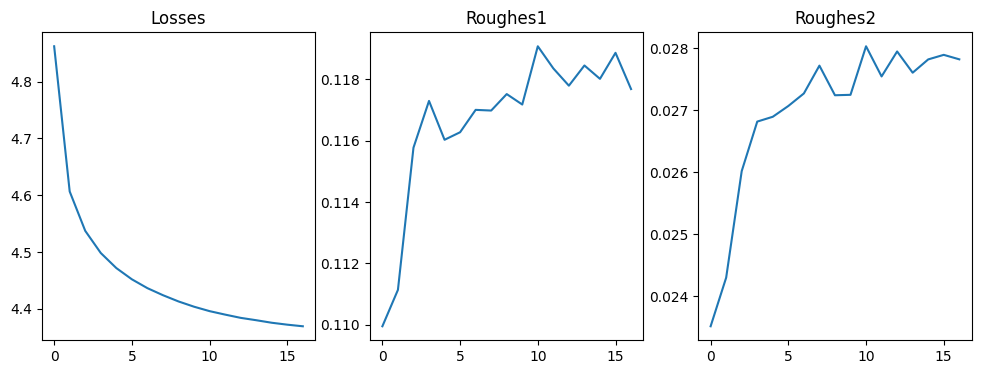

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].plot(losses)
axes[0].set_title("Losses")

axes[1].plot(roughes1)
axes[1].set_title("Roughes1")

axes[2].plot(roughes2)
axes[2].set_title("Roughes2")

plt.show()

In [8]:
torch.save(best_weights, 'models/next_token_lstm.pth')

### Тестирование и сравнение с трансформером 

#### Результаты LSTM

In [ ]:
subset = Subset(test_dataset, indices=list(range(20000))) ## Тестировал на локалке, поэтому обрезаю
test_loader = DataLoader(subset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
print(len(test_loader))

79


In [16]:
from src.next_token_rnn import NextTokenRNN

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
trained_lstm = NextTokenRNN(vocab_size=bert_tokenizer.vocab_size, 
                            emb_dim = 300, 
                            hidden_dim=256, 
                            num_layers=2)

trained_lstm.load_state_dict(torch.load('models/next_token_lstm.pth', map_location='cpu'))
trained_lstm

NextTokenRNN(
  (embedding): Embedding(30522, 300, padding_idx=0)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True)
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=30522, bias=True)
)

In [ ]:
from src.evaluate_one_epoch import evaluate_epoch
rough1_lstm, rough2_lstm, starts, trues, preds_lstm = evaluate_epoch(trained_lstm, test_loader, device, bert_tokenizer)
rough1_lstm, rough2_lstm

100%|██████████| 79/79 [57:47<00:00, 43.90s/it]  


(np.float64(0.11139191755587848), np.float64(0.020497493091002704))

In [ ]:
print(f'LSTM testing metrics: \n rough1: {rough1_lstm:.4f} \n rough2: {rough2_lstm:.4f}')

LSTM testing metrics: 
 rough1: 0.1114 
 rough2: 0.0205


In [ ]:
for i in range(5): 
    show_example = np.random.randint(0, len(starts))
    print(f'Example {i+1}: \n Start: {starts[show_example]} \n True: {trues[show_example]} \n Prediction: {preds_lstm[show_example]}')
        

Example 1: 
 Start: going to bed and it ' s 
 True: not 20 to 4 goodnight 
 Prediction: a beautiful day
Example 2: 
 Start: oh it ' s worth a roadtrip to portland they have way better 
 True: prices on nicer dresses plus no sales tax 
 Prediction: than the other one
Example 3: 
 Start: hi holly welcome to twitter lol looking forward 
 True: to tweeting with you 
 Prediction: to your tweets
Example 4: 
 Start: well this is day 2 sick at home and 
 True: it ' s my birthday tomorrow 
 Prediction: i ' m not going to be able to sleep
Example 5: 
 Start: texting the boy falling asleep on the boy getting woken up by the boy ha predictable cant 
 True: wait to see what you send me from england 
 Prediction: wait to see him


Text(0.5, 1.0, 'Длины автодополнений, сгенерированных LSTM')

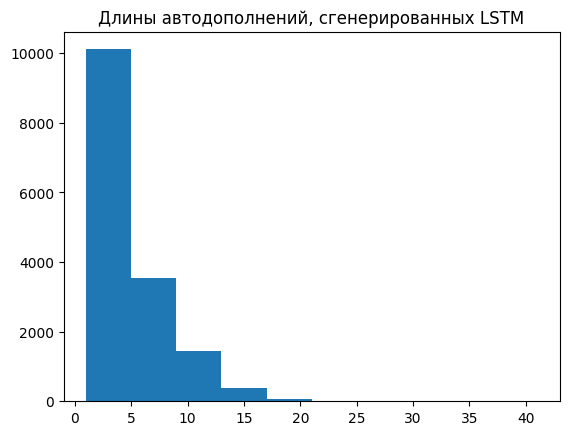

In [ ]:
plt.hist([len(pred.split()) for pred in preds_lstm])
plt.title('Длины автодополнений, сгенерированных LSTM')

In [ ]:
with open('lstm_preds.txt', 'w', encoding='utf-8') as f:
    for start, pred in zip(starts, preds_lstm):
        f.write(start + ' -- ' + pred + '\n')

#### Результаты трансформера

In [ ]:
from src.eval_transformer_pipeline import eval_transformer
rough1_gpt, rough2_gpt, gpt_preds = eval_transformer(starts, trues, "distilgpt2")

In [93]:
print(f'GPT testing metrics: \n rough1: {rough1_gpt:.4f} \n rough2: {rough2_gpt:.4f}')

GPT testing metrics: 
 rough1: 0.0708 
 rough2: 0.0055


In [87]:
for i in range(5): 
    show_example = np.random.randint(0, len(starts))
    print(f'Example {i+1}: \n Start: {starts[show_example]} \n True: {trues[show_example]} \n Prediction: {gpt_preds[show_example]}')
        

Example 1: 
 Start: hey ramiele the facebook thing there isn 
 True: ' t one with ur twitter pic ahhhhhh 
 Prediction: 't. I haven't gotten to this before so I'm going to try
Example 2: 
 Start: guess what my dad is pregnant lol nah the doctor does have to give him an 
 True: epidural for his chronic back pain though 
 Prediction:  ultrasound?
Example 3: 
 Start: sending out a big fu to the killer capital 
 True: c sad face 
 Prediction: , and then he'd get shot, and I'll never know if I
Example 4: 
 Start: ditto to that and we don 
 True: ' t expect you to lol 
 Prediction: 't have to worry about whether it's the same person who lost his wife
Example 5: 
 Start: don ' t u find annoying at 5 why not early in the morning a beautiful 
 True: day to be outside calling sick just kidding 
 Prediction:  woman is on the front page of the newsroom?'


Text(0.5, 1.0, 'Длины автодополнений, сгенерированных трансформером')

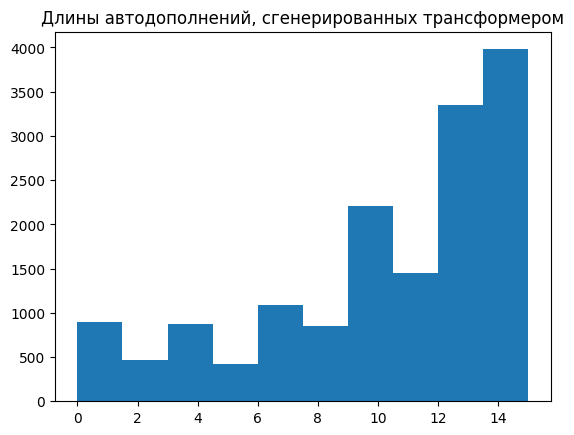

In [88]:
plt.hist([len(pred.split()) for pred in gpt_preds])
plt.title('Длины автодополнений, сгенерированных трансформером')

In [89]:
with open('gpt_preds.txt', 'w', encoding='utf-8') as f:
    for start, pred in zip(starts, gpt_preds):
        f.write(start + ' -- ' + pred + '\n')

#### Несколько сравнений автодополнений LSTM и трансформера

In [ ]:
for i in range(10): 
    show_example = np.random.randint(0, len(starts))
    print(f'Example {i+1}: \n Start: {starts[show_example]} \n True: {trues[show_example]} \n LSTM prediction: {preds_lstm[show_example]} \n Transformer prediction: {gpt_preds[show_example]} \n\n\n')
        

Example 1: 
 Start: so who ' s in the city hit us uppp nor 
 True: ##ita with the girls what ' s everyone up to tonight 
 LSTM prediction: the world is going to be a good day 
 Transformer prediction:  do we do this and have our name stamped on it,' Mr. King 



Example 2: 
 Start: glad you enjoyed it hunni now i can say the hard job of all 
 True: the week ended now tired kitty 
 LSTM prediction: the time 
 Transformer prediction:  of us is to get it done.Advertisements 



Example 3: 
 Start: it ' s a good day to be a paguyo my cousin just had her first mall show for 
 True: her collection she ' s the only reason i know i ' m not adopted 
 LSTM prediction: me 
 Transformer prediction:  the first time,' she said. 



Example 4: 
 Start: np and aw thanks yours does as well its 
 True: an amazing photograph 
 LSTM prediction: not a good thing 
 Transformer prediction:  website as the author’s blog http://www.hokd 



Example 5: 
 Start: no i ' m in the us for 
 True: the weekend not the

## Выводы

 - Модель архитекутры LSTM показывает лучшие метрики качества генерации текста на данном наборе коротких твитов. Модель пытается логично завершить предложение/фразу, генерируя типичные для разгооврного английского выражения. При анализе снегерированных LSTM текстов видно, что зачастую при генерации учитывается и контекст входа. 

 - Модель архитектуры трансформер по метрикам показывает худшее качество генерации коротких автодополнений. По анализам текстов видно, что модель генерирует достаточно несвязные продолжения входных текстов, пытается сгенерировать более длинные тексты. Предположительно, трансформер "ожидает" большего контекста, поскольку обучен на корпусах больших текстов. 

 - Учитывая требование использования модели генерации автодополнений на мобильных устройствах, рекомендуется использовать менее объемную модель архитектуры LSTM. 